In [1]:
import sys
sys.path.append('../')

In [2]:
"""
Standard protocol
"""

from deep_rl import *
import pickle
import uuid
import torch
import matplotlib.pyplot as plt

# Class for avDSR actor
class avDSRActorRandom(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()

        config = self.config # DELETE this line

        # Predict action
        # action = np.random.randint(self.config.action_dim)
        state_norm = config.state_normalizer(self._state)
        action = epsilon_greedy(1, torch.zeros(state_norm.shape[0], self.config.action_dim))
        # import pdb; pdb.set_trace()

        # Take action
        next_state, reward, done, info = self._task.step(action)

        entry = [self._state, action, reward, next_state, done, info]
        self._total_steps += 1
        self._state = next_state
        return entry

# Class for avDSR agent
class avDSRAgent(BaseAgent):
    def __init__(self, config, agents=None):
        """
            agents -> list of agents whose actions we need to sample.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()

        self.replay = config.replay_fn()
        if(agents is None):
            self.actor = avDSRActorRandom(config)
            self.config.style = 'random'
        else:
            raise NotImplementedError

        self.network = config.network_fn()
        self.network.share_memory()

        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.optimizer_phi = config.optimizer_fn(list(self.network.encoder.parameters()) + \
                                                 list(self.network.decoder.parameters()))
        self.optimizer_psi = config.optimizer_fn(self.network.layers_sr.parameters())


        self.actor.set_network(self.network)
        self.total_steps = 0
        self.c = 1

        try:
            self.is_wb = config.is_wb
        except:
            print('is_wb config not found, using deafult.')
            self.is_wb = True

        self.track_loss = True
        if(self.track_loss):
            self.loss_rec_vec = []
            self.loss_psi_vec = []
            self.loss_vec = []

        if(self.is_wb):
            wandb.init(entity="psurya", project="sample-project")
            wandb.watch_called = False

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def reduce_loss(self, loss):
        return loss.pow(2).mul(0.5).mean()

    def compute_loss(self, transitions):
        config = self.config
        states = self.config.state_normalizer(transitions.state)
        next_states = self.config.state_normalizer(transitions.next_state)
        masks = tensor(transitions.mask)
        rewards = tensor(transitions.reward)
        actions = tensor(transitions.action).long()
        with torch.no_grad():
            psi_next = self.network(next_states)['psi'].detach()

        if(self.config.style == 'random'):
            next_actions = tensor(epsilon_greedy(1, torch.zeros(psi_next.shape[0], self.config.action_dim))).long()
        else:
            raise NotImplementedError
            
        psi_next = psi_next[:, next_actions, :]
        out = self.network(states)
        psi_next = self.config.discount * psi_next * (masks.unsqueeze(1).unsqueeze(2).expand(-1, 32,512))
        phi, psi, state_rec = out['phi'], out['psi'], out['state_rec']
        psi_next.add_(phi.clone())
        psi = psi[:, actions, :]

        loss_rec = (state_rec - tensor(states))
        loss_psi = (psi_next - psi)

        return loss_rec, loss_psi

    def step(self):
        config = self.config
        # Step and get new transisions
        transitions = self.actor.step()

        for states, actions, rewards, next_states, dones, info in transitions:

            # Recording results
            self.record_online_return(info) # to log, screen
            for i, info_ in enumerate(info): # to wandb
                ret = info_['episodic_return']
                if ret is not None:
                    if(self.is_wb):
                        wandb.log({"steps_ret": self.total_steps, "returns": ret})

            self.total_steps += 1

            # Feed the transisions into replay
            self.replay.feed(dict(
                state=np.array([s[-1] if isinstance(s, LazyFrames) else s for s in states]),
                action=actions,
                reward=[config.reward_normalizer(r) for r in rewards],
                mask=1 - np.asarray(dones, dtype=np.int32),
            ))

        if self.total_steps > self.config.exploration_steps:

            transitions = self.replay.sample()
            # import pdb; pdb.set_trace()
            loss_rec, loss_psi = self.compute_loss(transitions)
            loss_rec, loss_psi = self.reduce_loss(loss_rec), self.reduce_loss(loss_psi)
            loss = (loss_psi + self.c * loss_rec).mean()

            if(self.track_loss):
                self.loss_vec.append(loss.item())
                self.loss_psi_vec.append(loss_psi.item())
                self.loss_rec_vec.append(loss_rec.item())

            if(self.is_wb):
                wandb.log({"steps_loss": self.total_steps, "loss": loss.item()})


            self.optimizer.zero_grad()
            loss_rec.backward(retain_graph=True)
            loss_psi.backward()
            with config.lock:
                self.optimizer_psi.step()
            with config.lock:
                self.optimizer_phi.step()

# Class for network 
class SRNetNatureUnsup(nn.Module):
    def __init__(self, output_dim, hidden_units_sr=(512*4,), hidden_units_psi2q=(), gate=F.relu, config=1):
        """
        This network has two heads: SR head (SR) and reconstruction head (rec).
        config -> type of learning on top of state abstraction
            0 - typical SR with weights sharing
            1 - learning SR without weights sharing
        """
        super(SRNetNatureUnsup, self).__init__()
        self.feature_dim = 512
        self.output_dim = output_dim
        self.gate = gate
        in_channels = 4
        
        self.encoder = nn.Sequential(
            layer_init(nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)),  # b, 16, 10, 10
            nn.ReLU(True),
            layer_init(nn.Conv2d(32, 64, kernel_size=4, stride=2)), 
            nn.ReLU(True),
            layer_init(nn.Conv2d(64, 64, kernel_size=3, stride=1)), 
            nn.ReLU(True),
            Flatten(),
            nn.Linear(7 * 7 * 64, self.feature_dim)
        )
        
        self.decoder = nn.Sequential(
            layer_init(nn.Linear(self.feature_dim, 7 * 7 * 64)),
            torch_reshape(into=[64, 7, 7]),
            layer_init(nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1)),  # b, 16, 5, 5
            nn.ReLU(True),
            layer_init(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2)),  # b, 16, 5, 5
            nn.ReLU(True),
            layer_init(nn.ConvTranspose2d(32, in_channels, kernel_size=8, stride=4, output_padding=0)),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.Tanh()
        )

        # layers for SR
        dims_sr = (self.feature_dim,) + hidden_units_sr + (self.feature_dim * output_dim,)
        self.layers_sr = nn.ModuleList(
            [layer_init_0(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims_sr[:-1], dims_sr[1:])])

        self.to(Config.DEVICE)

    def forward(self, x):

        # Finding the latent layer
        phi = self.encoder(tensor(x)) # shape: b x state_dim

        # Reconstruction
        state_rec = self.decoder(phi)

        # Estimating the SR from the latent layer
        psi = phi
        for layer in self.layers_sr[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers_sr[-1](psi)
        psi = psi.view(psi.size(0), self.output_dim, self.feature_dim) # shape: b x action_dim x state_dim

        return dict(phi=phi, psi=psi, state_rec=state_rec)

# Function for unsupervised representation learning
def dsr_unsup_pixel(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    kwargs.setdefault('n_step', 1)
    kwargs.setdefault('replay_cls', UniformReplay)
    kwargs.setdefault('async_replay', False)
    kwargs.setdefault('is_wb', False)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr=0.0005)
    config.network_fn = lambda: SRNetNatureUnsup(output_dim=config.action_dim)
    # config.network_fn = lambda: DuelingNet(config.action_dim, NatureConvBody(in_channels=config.history_length))
    config.random_action_prob = LinearSchedule(1.0, 1.0, 1e6)
    config.batch_size = 32
    config.discount = 0.99
    config.history_length = 4
    config.max_steps = int(1e5)
    replay_kwargs = dict(
        memory_size=int(1e6),
        batch_size=config.batch_size,
        n_step=config.n_step,
        discount=config.discount,
        history_length=config.history_length,
    )
    config.replay_fn = lambda: ReplayWrapper(config.replay_cls, replay_kwargs, config.async_replay)
    config.replay_eps = 0.01
    config.replay_alpha = 0.5
    config.replay_beta = LinearSchedule(0.4, 1.0, config.max_steps)

    config.state_normalizer = ImageNormalizer()
    config.reward_normalizer = SignNormalizer()
    config.target_network_update_freq = None
    config.exploration_steps = 1000
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.double_q = False
    config.async_actor = False
    return run_steps(avDSRAgent(config))

def run_steps(agent):
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            agent.close()
            break
        agent.step()
        agent.switch_task()
    return agent

In [3]:
select_device(0)

In [4]:
game='BoxingNoFrameskip-v0'
avdsr = dsr_unsup_pixel(game=game)

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
2020-10-14 09:00:08,210 - root - INFO: steps 0, 23563505.62 steps/s
2020-10-14 09:00:09,830 - root - INFO: steps 1000, 619.57 steps/s
2020-10-14 09:00:26,476 - root - INFO: steps 1777, episodic_return_train -2.0
2020-10-14 09:00:28,083 - root - INFO: steps 2000, 54.79 steps/s
2020-10-14 09:00:35,209 - root - INFO: steps 3000, 140.38 steps/s
2020-10-14 09:00:39,204 - root - INFO: steps 3559, episodic_return_train 1.0
2020-10-14 09:00:42,372 - root - INFO: steps 4000, 139.68 steps/s
2020-10-14 09:00:49,495 - root - INFO: steps 5000, 140.45 steps/s
2020-10-14 09:00:51,915 - root - INFO: steps 5338, episodic_return_train 3.0
2020-10-14 09:00:56,631 - root - INFO: steps 6000, 140.20 steps/s
2020-10-14 09:01:03,706 - root - INFO: steps 7000, 141.37 step

In [5]:
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize)/kernelSize, 'valid')
    return array

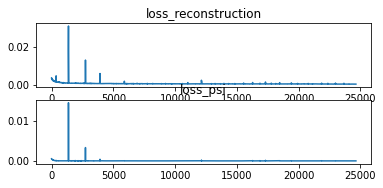

In [13]:
plt.subplot(311), plt.plot(convolve(avdsr.loss_rec_vec,10)[100:]), plt.title('loss_reconstruction')
plt.subplot(312), plt.plot(convolve(avdsr.loss_psi_vec,10)[100:]), plt.title('loss_psi')
plt.show()

In [7]:
import gym
from gym.spaces.box import Box
from gym.spaces.discrete import Discrete
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
from baselines.common.atari_wrappers import FrameStack as FrameStack_
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv, VecEnv
class TransposeImage(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(TransposeImage, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            [obs_shape[2], obs_shape[1], obs_shape[0]],
            dtype=self.observation_space.dtype)

    def observation(self, observation):
        return observation.transpose(2, 0, 1)
    
class FrameStack(FrameStack_):
    def __init__(self, env, k):
        FrameStack_.__init__(self, env, k)

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))
    
class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.

        This object should only be converted to numpy array before being passed to the model.

        You'd not believe how complex the previous solution was."""
        self._frames = frames

    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self.__array__())

    def __getitem__(self, i):
        return self.__array__()[i]

In [8]:
env_id='BoxingNoFrameskip-v0'
env = make_atari(env_id)
env = wrap_deepmind(env, episode_life=True, clip_rewards=False, frame_stack=False, scale=False)
obs_shape = env.observation_space.shape
if len(obs_shape) == 3:
    env = TransposeImage(env)
env = FrameStack(env, 4)
obs = env.reset()

/home/mila/p/penmetss/.conda/envs/conda_env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [266]:
obs,_,_,_ = env.step(env.action_space.sample())

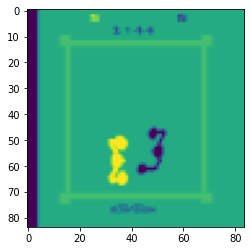

In [267]:
plt.imshow(obs[1,:,:])

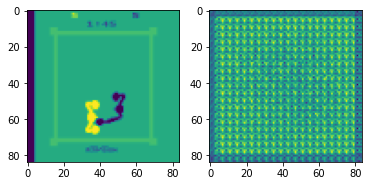

In [296]:
obs2 = tensor(obs)/255
out = avdsr.network(obs2.unsqueeze(0))
re_np = out['state_rec'].squeeze(0).detach().cpu().numpy()
imgIn = tensor(obs).cpu().numpy()[0,:,:]
imgRe = re_np[0,:,:]

plt.subplot(121), plt.imshow(imgIn)
plt.subplot(122), plt.imshow(imgRe); plt.show()

In [21]:
out['state_rec']

tensor([[[[0.2641, 0.2684, 0.2667,  ..., 0.2691, 0.2670, 0.2609],
          [0.2630, 0.2653, 0.2632,  ..., 0.2671, 0.2664, 0.2623],
          [0.2640, 0.2658, 0.2642,  ..., 0.2642, 0.2650, 0.2637],
          ...,
          [0.2632, 0.2677, 0.2672,  ..., 0.2620, 0.2643, 0.2643],
          [0.2653, 0.2615, 0.2659,  ..., 0.2662, 0.2648, 0.2653],
          [0.2614, 0.2693, 0.2629,  ..., 0.2641, 0.2652, 0.2638]],

         [[0.2656, 0.2634, 0.2638,  ..., 0.2613, 0.2664, 0.2654],
          [0.2618, 0.2662, 0.2626,  ..., 0.2631, 0.2644, 0.2682],
          [0.2652, 0.2678, 0.2643,  ..., 0.2684, 0.2661, 0.2713],
          ...,
          [0.2658, 0.2648, 0.2624,  ..., 0.2674, 0.2625, 0.2684],
          [0.2608, 0.2655, 0.2683,  ..., 0.2682, 0.2594, 0.2683],
          [0.2650, 0.2682, 0.2676,  ..., 0.2642, 0.2713, 0.2702]],

         [[0.2707, 0.2694, 0.2644,  ..., 0.2679, 0.2614, 0.2662],
          [0.2649, 0.2639, 0.2702,  ..., 0.2643, 0.2657, 0.2613],
          [0.2699, 0.2612, 0.2655,  ..., 0

In [22]:
transitions = avdsr.replay.sample()
states = avdsr.config.state_normalizer(transitions.state)
out = avdsr.network(states)
phi, psi, state_rec = out['phi'], out['psi'], out['state_rec']
loss_rec = (state_rec - tensor(states)).pow(2).mul(0.5).mean()

In [23]:
loss_rec

tensor(0.0342, device='cuda:0', grad_fn=<MeanBackward0>)

In [295]:
# torch.save(avdsr.network.state_dict(), '../storage/41-avdsr-trained-boxing-5e-4-1e5.weights')
# torch.save(avdsr.network.state_dict(), '../storage/41-avdsr-trained-boxing-5e-4-1e5-shuffle.weights')

In [292]:
weights = avdsr.network.state_dict()

In [293]:
for k in weights.keys():
    l_shape = weights[k].shape
    weights2 = weights[k].view(-1)
    r = torch.randperm(weights2.shape[0])
    weights2 = weights2[r]
    weights[k] = weights2.view(l_shape)

In [299]:
avdsr.network.state_dict().keys()

odict_keys(['encoder.0.weight', 'encoder.0.bias', 'encoder.2.weight', 'encoder.2.bias', 'encoder.4.weight', 'encoder.4.bias', 'encoder.7.weight', 'encoder.7.bias', 'decoder.0.weight', 'decoder.0.bias', 'decoder.2.weight', 'decoder.2.bias', 'decoder.4.weight', 'decoder.4.bias', 'decoder.6.weight', 'decoder.6.bias', 'layers_sr.0.weight', 'layers_sr.0.bias', 'layers_sr.1.weight', 'layers_sr.1.bias'])

In [294]:
avdsr.network.load_state_dict(weights)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [290]:
avdsr.network.load_state_dict(torch.load('../storage/41-avdsr-trained-boxing-5e-4-1e5.weights'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])